A notebook for visualizing the results of the script fit_one_dim_synthesis_example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import os
import pathlib

import matplotlib
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.math.basic_functions import list_grid_pts
from janelia_core.ml.fitting import match_torch_module
from janelia_core.math.basic_functions import bound
from janelia_core.math.basic_functions import pts_in_arc
from janelia_core.ml.utils import list_torch_devices
from janelia_core.stats.regression import corr
from janelia_core.stats.regression import r_squared

from probabilistic_model_synthesis.gaussian_nonlinear_regression import approximate_elbo
from probabilistic_model_synthesis.gaussian_nonlinear_regression import eval_check_point_perf
from probabilistic_model_synthesis.gaussian_nonlinear_regression import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_regression import load_check_points
from probabilistic_model_synthesis.gaussian_nonlinear_regression import predict
from probabilistic_model_synthesis.gaussian_nonlinear_regression import PosteriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_regression import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_regression import VICollection
from probabilistic_model_synthesis.simulation import efficient_cone_and_projected_interval_sample

In [3]:
%matplotlib notebook

## Parameters go here 

In [4]:
# Location of folder with the results we should visualize
rs_folder = r'/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/results/publication_results/gnlr/simulation'

# File holding fitting results
rs_file = 'full_simulations.pt'

# Sub-folders holding check points
combined_cp_folder = 'comb_cps'
single_cp_folder = 'single_cps'

# Type of results we should look at - combined or single
rs_type = 'combined'

# True if we should look at fitting logs
vis_fit_logs = True

# Index of the example system we should visualize results for
ex_s_i = 1 # 1 is a good example

# Number of samples we use for validation data when performing early stopping
n_validation_smps = 1000

# Number of samples we generate for evaluating model performance
n_eval_smps = 10000

# Location we should save plots to - if this folder doesn't exist we will create it 
save_loc = r'/groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/results/publication_results/gnlr/simulation'

## Determine if GPU is availalbe 

In [5]:
compute_devices, gpu_available = list_torch_devices()
if gpu_available:
    compute_device = compute_devices[0]
else:
    compute_device = torch.device('cpu')

Found 1 GPUs


## Load results and prepare what we need for later analysis

In [6]:
rs_file_path = pathlib.Path(rs_folder) / rs_file

In [7]:
rs = torch.load(rs_file_path)

Pull out constants, paths, etc we will need below

In [8]:
n_ex_systems = rs['ps']['n_ex_systems']

subj_props = rs['ind_props']
fit_ps = rs['ps']
single_fit_inds = rs['ps']['single_fit_inds']
n_single_fit_systems = len(single_fit_inds)

combined_cp_folder = pathlib.Path(rs_folder) / combined_cp_folder
single_cp_folder = pathlib.Path(rs_folder) / single_cp_folder

## Apply retroactive early stopping to synthesized models and for model fit individually

Generate validation data for each subject 

In [9]:
eval_data = [None]*n_ex_systems
for s_i in range(n_ex_systems):
    
    # We generate data with the same active neurons and behevioral range as was in the training data for
    # this subject
    with torch.no_grad():
        x_i_validation = efficient_cone_and_projected_interval_sample(n_smps=n_validation_smps,
                                                                        locs=rs['ind_props'][s_i],
                                                                        ctr=torch.tensor([.5, .5]),
                                                                        ang_range=rs['ang_ranges'][s_i],
                                                                        w=rs['ind_true_mdls'][s_i].w.detach(),
                                                                        interval=rs['ind_intervals'][s_i],
                                                                        big_std=1.0,
                                                                        small_std=0,
                                                                        device=compute_device)
    
        # Before generating y data, move model to GPU (if possible)
        rs['ind_true_mdls'][s_i].to(compute_device)
        y_i_validation = rs['ind_true_mdls'][s_i].sample(x=x_i_validation)
        
        # Move data back to cpu to save GPU memory
        x_i_validation = x_i_validation.to('cpu')
        y_i_validation = y_i_validation.to('cpu')
        
        eval_data[s_i] = (x_i_validation, y_i_validation)
    

Evaluate check point performance for the synthesized models

In [10]:
comb_sp_cps, comb_sp_cp_epochs = load_check_points(cp_dir=combined_cp_folder, cp_str='cp_sp')
comb_ip_cps, comb_ip_cp_epochs = load_check_points(cp_dir=combined_cp_folder, cp_str='cp_ip')

comb_sp_perf = eval_check_point_perf(cps=comb_sp_cps, eval_data=eval_data, subj_props=subj_props, 
                                     eval_device=compute_device)

comb_ip_perf = eval_check_point_perf(cps=comb_ip_cps, eval_data=eval_data, subj_props=subj_props, 
                                     eval_device=compute_device)

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Define a smaller helper function for plotting check point performance 

In [11]:
def plot_cp_perf(plt_epochs, perf_vls, ax):
    
    n_subjs = perf_vls.shape[1]
    for s_i in range(n_subjs):
        ax.plot(plt_epochs, perf_vls[:, s_i])
    
    if n_subjs > 1:
        ax.plot(plt_epochs, np.mean(perf_vls, axis=1), 'k-', linewidth=4)

Plot performance across check points

<IPython.core.display.Javascript object>


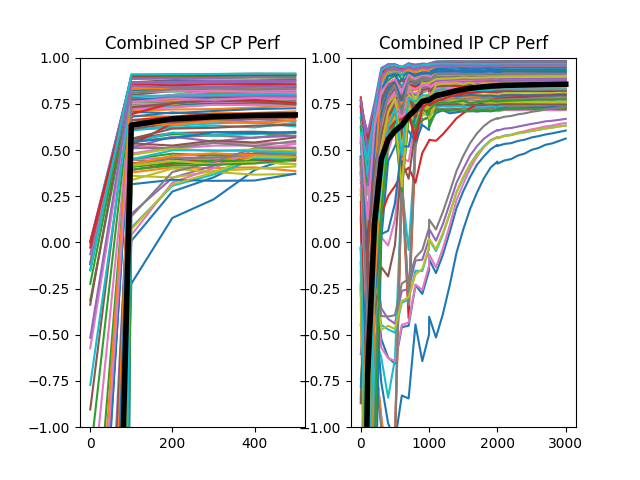

Text(0.5, 1.0, 'Combined IP CP Perf')

In [12]:
plt.figure()
ax = plt.subplot(1,2,1)
plot_cp_perf(comb_sp_cp_epochs, comb_sp_perf, ax)
plt.ylim([-1, 1])
plt.title('Combined SP CP Perf')

ax = plt.subplot(1,2,2)
plot_cp_perf(comb_ip_cp_epochs, comb_ip_perf, ax)
plt.ylim([-1, 1])
plt.title('Combined IP CP Perf')


Pick the best check point for the synthesized models

We pick only check points for models with individual posteriors (as we consider fitting with shared posteriors to be an initiliazation step).  We pick one check point for all subjects - as all models are synthesized together. 

In [13]:
best_comb_ip_cp_ind = np.argmax(np.mean(comb_ip_perf, axis=1))

comb_vi_colls = [VICollection.from_checkpoint(comb_ip_cps[best_comb_ip_cp_ind]['vi_collections'][s_i])
                 for s_i in range(n_ex_systems)]

comb_priors = PriorCollection.from_checkpoint(comb_ip_cps[best_comb_ip_cp_ind]['priors'])

Evaluate performance for the models fit to individual systems

In [14]:
single_cp_perf = [None]*n_single_fit_systems
for i, s_i in enumerate(single_fit_inds):
    
    cp_folder_i = single_cp_folder / ('s_' + str(s_i))


    single_sp_cps_i, single_sp_cp_epochs_i = load_check_points(cp_dir=cp_folder_i, cp_str='cp_sp')
    single_ip_cps_i, single_ip_cp_epochs_i = load_check_points(cp_dir=cp_folder_i, cp_str='cp_ip')

    single_sp_perf_i = eval_check_point_perf(cps=single_sp_cps_i, eval_data=[eval_data[s_i]], 
                                             subj_props=[subj_props[s_i]], 
                                             eval_device=compute_device)

    single_ip_perf_i = eval_check_point_perf(cps=single_ip_cps_i, eval_data=[eval_data[s_i]], 
                                             subj_props=[subj_props[s_i]], 
                                             eval_device=compute_device)
    
    single_cp_perf[i] = {'sp_epochs': single_sp_cp_epochs_i, 'sp_perf': single_sp_perf_i, 
                           'ip_epochs': single_ip_cp_epochs_i, 'ip_perf': single_ip_perf_i, 
                            'sp_cps': single_sp_cps_i, 'ip_cps': single_ip_cps_i}

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Done loading check point 1 of 6.
Done loading check point 2 of 6.
Done loading check point 3 of 6.
Done loading check point 4 of 6.
Done loading check point 5 of 6.
Done loading check point 6 of 6.
Done loading check point 1 of 33.
Done loading check point 2 of 33.
Done loading check point 3 of 33.
Done loading check point 4 of 33.
Done loading check point 5 of 33.
Done loading check point 6 of 33.
Done loading check point 7 of 33.
Done loading check point 8 of 33.
Done loading check point 9 of 33.
Done loading check point 10 of 33.
Done loading check point 11 of 33.
Done loading check point 12 of 33.
Done loading check point 13 of 33.
Done loading check point 14 of 33.
Done loading check point 15 of 33.
Done loading check point 16 of 33.
Done loading check point 17 of 33.
Done loading check point 18 of 33.
Done loading check point 19 of 33.
Done loading check point 20 of 33.
Done loading check point 21 of 33.
Done loading check point 22 of 33.
Done loading check point 23 of 33.
Done l

Plot performance across check points

<IPython.core.display.Javascript object>


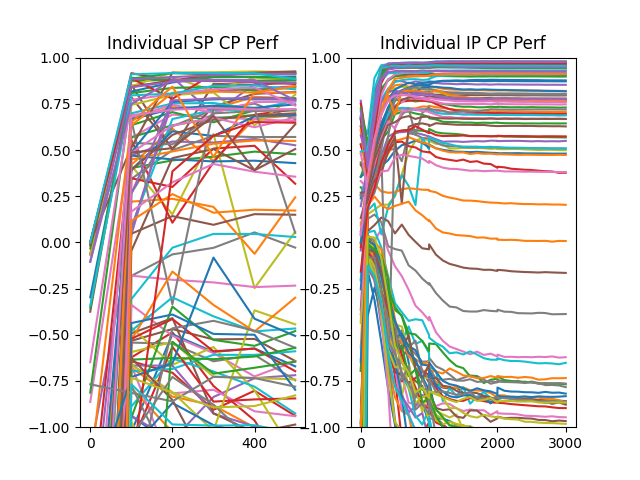

Text(0.5, 1.0, 'Individual IP CP Perf')

In [15]:
plt.figure()
ax = plt.subplot(1,2,1)
for i in range(n_single_fit_systems):
    plot_cp_perf(single_cp_perf[i]['sp_epochs'], single_cp_perf[i]['sp_perf'], ax)
plt.ylim([-1, 1])
plt.title('Individual SP CP Perf')

ax = plt.subplot(1,2,2)
for i in range(n_ex_systems):
    plot_cp_perf(single_cp_perf[i]['ip_epochs'], single_cp_perf[i]['ip_perf'], ax)
plt.ylim([-1, 1])
plt.title('Individual IP CP Perf')

Pick the best check point for each model fit to an example system in isolation 

In [16]:
single_fits = [None]*n_single_fit_systems
for i in range(n_single_fit_systems):
    best_cp_ind = np.argmax(single_cp_perf[i]['ip_perf'])
    
    single_fits[i] = {'vi_coll': VICollection.from_checkpoint(
         single_cp_perf[i]['ip_cps'][best_cp_ind]['vi_collections'][0]), 
                      'priors': PriorCollection.from_checkpoint(single_cp_perf[i]['ip_cps'][best_cp_ind]['priors'])}


## Pick key quantities we need when showing results below

In [17]:
single_ex_i = np.argwhere(np.asarray(single_fit_inds) == ex_s_i).item()

In [18]:
# Determine the domain of the shared m function
min_interval = np.min(np.asarray(rs['ind_intervals']))
max_interval = np.max(np.asarray(rs['ind_intervals']))
min_l_range = min_interval*fit_ps['s_in']
max_l_range = max_interval*fit_ps['s_in']

# Pull out neurons, their properties and true weights for the example system we use for visualization 
ex_active_neurons = np.asarray((torch.var(rs['ind_data'][ex_s_i][0], dim=0) > 1E-10).tolist())
ex_neuron_props = rs['ind_props'][ex_s_i]
ex_true_neuron_weights = rs['ind_true_mdls'][ex_s_i].w.detach().cpu().numpy()

# Pull out true CPD
true_priors = rs['true_priors']

if rs_type == 'combined':
    # The fit logs we plot
    fit_logs = rs['comb_fit_rs']['ip']['logs']
    # The range the shared function should be learnable over 
    m_fit_range = torch.tensor([[min_l_range], [max_l_range]])
    # The fit shared function
    m_fit = comb_vi_colls[0].mdl.m
    # The posterior mean over neuron weights for the example system
    ex_w_fit_mn = comb_vi_colls[ex_s_i].posteriors.w_post(ex_neuron_props).detach().cpu().numpy()
    # The fit CPD
    fit_priors = comb_priors

elif rs_type == 'single':
    # The fit logs we plot
    fit_logs = rs['single_fit_rs'][single_ex_i]['ip']['logs']
    # The range the shared function should be learnable over 
    m_fit_range = torch.tensor([[rs['ind_intervals'][ex_s_i][0]], [rs['ind_intervals'][ex_s_i][1]]], dtype=torch.float32)*fit_ps['s_in']
    # The fit shared function
    m_fit = single_fits[single_ex_i]['vi_coll'].mdl.m
    # The posterior mean over neuron weights for the example system
    ex_w_fit_mn = single_fits[single_ex_i]['vi_coll'].posteriors.w_post(ex_neuron_props).detach().cpu().numpy()
    # The fit CPD
    fit_priors = single_fits[single_ex_i]['priors']

## Examine fitting logs, if requested 

<IPython.core.display.Javascript object>


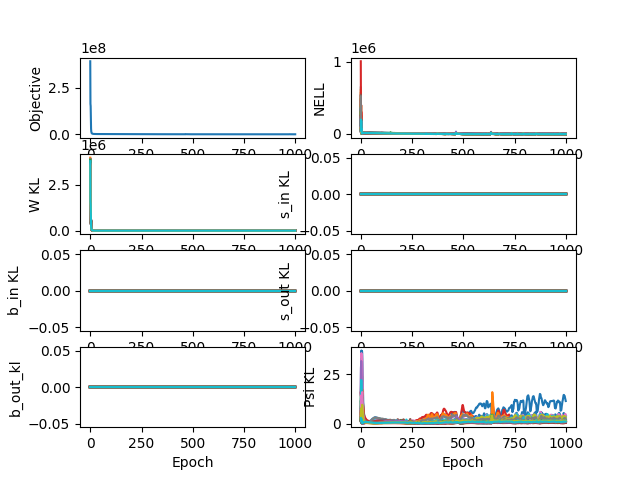

<IPython.core.display.Javascript object>


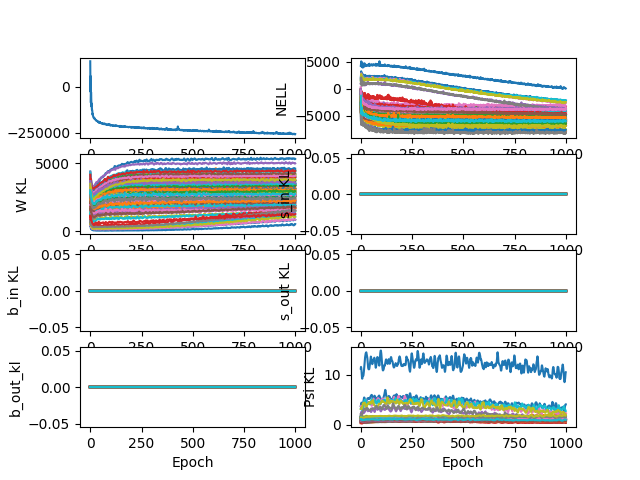

<IPython.core.display.Javascript object>


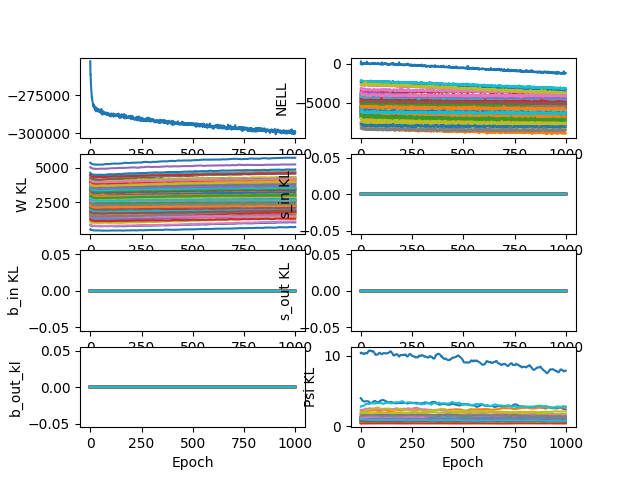

In [19]:
if vis_fit_logs:
    for log in fit_logs:
        Fitter.plot_log(log)

## Create folder to save results into if needed

In [20]:
save_folder = pathlib.Path(save_loc)
type_save_loc = save_folder / (rs_type + '_images')
if not os.path.isdir(save_loc):
    print('Creating folder to save plots into: ' + str(save_folder))
    os.makedirs(save_folder)
    
if not os.path.isdir(type_save_loc):
    print('Creating folder to save plots into: ' + str(type_save_loc))
    os.makedirs(type_save_loc)

Creating folder to save plots into: /groups/fitzgerald/fitzgeraldlab/bishoplab/projects/probabilistic_model_synthsis/results/publication_results/gnlr/simulation/combined_images


## Define some helper functions

In [21]:
# Helper formatting function
def format_box(ax):
    ax.set_aspect('equal', 'box')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.xlabel('property dim 1 (a.u.)')
    plt.ylabel('property dim 2 (a.u.)')

In [22]:
# Helper function for evaluating model performance

def eval_mdl_perf(eval_x: torch.Tensor, eval_y: torch.Tensor, coll, priors, n_elbo_smps=100):

    with torch.no_grad():
        y_hat = predict(coll=coll, x=eval_x, sample=False).cpu().numpy()

    # Measure performance of the predictions
    eval_r_sq = r_squared(eval_y.cpu().numpy(), y_hat) 

    
    eval_corr = corr(eval_y.cpu().numpy(), y_hat) 
    
    # Measure the ELBO for the fit models on the data in the training domain
    orig_data = coll.data
    coll.data = [eval_x, eval_y]
    with torch.no_grad():
        eval_elbo = approximate_elbo(coll=coll, priors=priors, n_smps=n_elbo_smps, 
                                     skip_s_in_kl=True, skip_b_in_kl=True, skip_s_out_kl=True, 
                                     skip_b_out_kl=True)
    
    return {'r_sq': eval_r_sq, 'corr': eval_corr, 'elbo': eval_elbo['elbo'].cpu().numpy(), 
            'decomposed_elbo': eval_elbo, 'y_true': eval_y.cpu().numpy(), 'y_hat': y_hat}
    

In [23]:


def vis_perf(eval_rs: dict, ax, metric='r_sq', min_vl=None, min_plot_vl = None, max_plot_vl = None, 
             title=None, ex_i = None):
    """ 
    Plots relative performance of models fit to combined data vs individual data. 
    
    In particular makes scatter plots of performance comparing what happens when we fit 
    models together with DPMS vs. fitting to individual example systems alone
    """
    
    comb_train_domain_vls = np.asarray([rs['comb_train_domain_perf'][metric].item() for rs in eval_rs])
    sing_train_domain_vls = np.asarray([rs['sing_train_domain_perf'][metric].item() for rs in eval_rs])
    
    comb_full_vls = np.asarray([rs['comb_full_perf'][metric].item() for rs in eval_rs])
    sing_full_vls = np.asarray([rs['sing_full_perf'][metric].item() for rs in eval_rs])
    
    # Enforce min value if we are suppose to
    if min_vl is not None:
        comb_train_domain_vls = bound(comb_train_domain_vls, min_vl, np.inf)
        sing_train_domain_vls = bound(sing_train_domain_vls, min_vl, np.inf)
        comb_full_vls = bound(comb_full_vls, min_vl, np.inf)
        sing_full_vls = bound(sing_full_vls, min_vl, np.inf)

    # Generate plot
    all_vls = np.concatenate([comb_train_domain_vls, sing_train_domain_vls, comb_full_vls, sing_full_vls])
    if min_plot_vl is None:
        min_plot_vl = np.min(all_vls)
    if max_plot_vl is None:
        max_plot_vl= np.max(all_vls)
    
    ax.plot([min_plot_vl, max_plot_vl], [min_plot_vl, max_plot_vl], 'k--', label='_nolegend_')
    ax.plot(sing_train_domain_vls, comb_train_domain_vls, 'k.',)
    ax.plot(sing_full_vls, comb_full_vls, '.', color='gray')
    
    if ex_i is not None:
        ax.plot(sing_train_domain_vls[ex_i], comb_train_domain_vls[ex_i], 'ko', markerfacecolor='none',
                markersize=15)
        ax.plot(sing_full_vls[ex_i], comb_full_vls[ex_i], 'o', markerfacecolor='none',
                markersize=15, color='gray')
    
    plt.legend(['within training Distribution', 'out of training distribution'])
    if title is not None:
        plt.title(title)
    ax.set_aspect('equal', 'box')
    

In [24]:
def get_fit_to_true_cpd_scale(rs_type, fit_priors, true_priors, fit_pts, ang_range=None):
    """
    Learns the best scale to match the fit CPD to the true CPD. 
    
    """

    if rs_type == 'combined':
        sc_grid_pts = fit_pts
    elif rs_type == 'single':   
        sc_grid_pts, _ = list_grid_pts(grid_limits=np.asarray([[0, 1.0], [0, 1.0]]), n_pts_per_dim=[100,100])
        sc_grid_pts = torch.tensor(sc_grid_pts[pts_in_arc(sc_grid_pts, np.asarray([.5, .5]), ang_range),:])

    return  np.linalg.lstsq(fit_priors.w_prior(sc_grid_pts).detach().numpy(),
                            true_priors.w_prior(sc_grid_pts).detach().numpy(), rcond=None)[0].item()


## Visualize the active neurons for one example system

In [25]:
w_vis_min = np.min(ex_true_neuron_weights)
w_vis_max = np.max(ex_true_neuron_weights)
true_w_clrs = cm.viridis((ex_true_neuron_weights - w_vis_min)/(w_vis_max - w_vis_min)).squeeze()
true_w_clrs[~ex_active_neurons,3] = 1

<IPython.core.display.Javascript object>


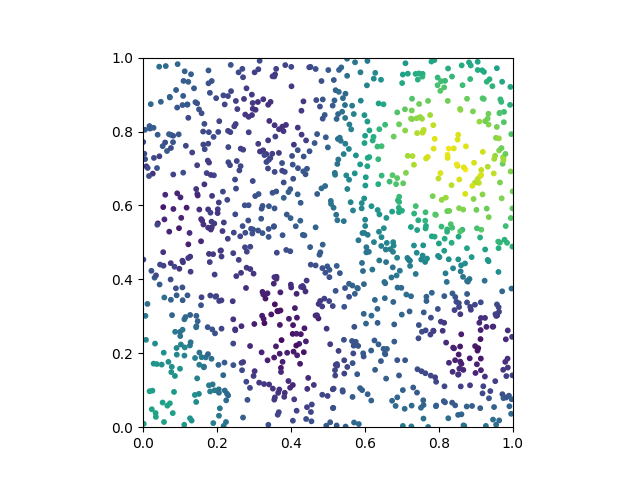

In [26]:
plt.figure()
ax = plt.subplot(1,1,1)

sub_smp_int = 10

# Plot active neurons 
ax.scatter(ex_neuron_props[::sub_smp_int,0], ex_neuron_props[::sub_smp_int,1], 
           marker='.', color=true_w_clrs[0::sub_smp_int,:], s=40)

plt.xlim([0, 1])
plt.ylim([0, 1])
ax.set_aspect('equal')
plt.savefig(save_folder / ('active_neurons_s_' + str(ex_s_i) + '.pdf'), format='pdf')

## Learn the scale that minimizes error between true and fit CPD

In [27]:
pts, dim_pts = list_grid_pts(grid_limits=np.asarray([[0, 1.0], [0, 1.0]]), n_pts_per_dim=[100,100])
pts = torch.tensor(pts, dtype=torch.float)

In [28]:
true_to_fit_cpd_sc = get_fit_to_true_cpd_scale(rs_type, fit_priors, true_priors, fit_pts=pts, 
                                               ang_range=rs['ang_ranges'][ex_s_i])

## Visualize the true and fit shared function 

In [29]:
m_true = rs['m_true']

l_plot_pts = np.linspace(min_l_range,max_l_range,1000)
m_true_pts = m_true(torch.tensor(l_plot_pts)).numpy()

In [30]:
m_fit_cp = copy.deepcopy(m_fit)
m_fit_scaled = torch.nn.Sequential(torch.nn.Linear(1, 1, bias=False), m_fit_cp)
m_fit_scaled[0].weight.data[0] = 1/true_to_fit_cpd_sc
m_fit_scaled = m_fit_scaled.cpu()

Plot the scaled and offset fit shared function

In [31]:
ex_int = np.asarray(rs['ind_intervals'][ex_s_i])/np.sqrt(rs['ps']['n_input_var_range'][0])
ex_int_w = ex_int[1] - ex_int[0]

In [32]:
m_fit_pts = m_fit_scaled(torch.tensor(l_plot_pts)).detach().numpy()

<IPython.core.display.Javascript object>


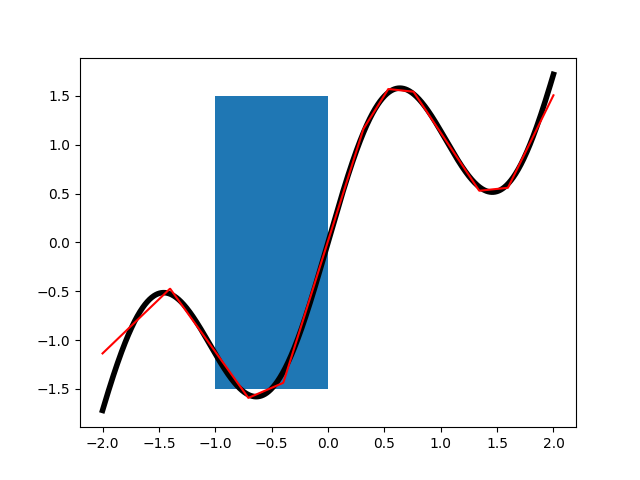

In [33]:
plt.figure()
ax = plt.subplot(1,1,1)
ax.add_patch(Rectangle([ex_int[0], -1.5], ex_int_w, 3.0))
ax.plot(l_plot_pts, m_true_pts, 'k-', linewidth=4)
ax.plot(l_plot_pts, m_fit_pts, 'r-')
plt.savefig(type_save_loc / 'm_fit.pdf', format='pdf')

## Visualize the fit mean of the posterior over weights for the example subject 

In [34]:
w_fit_mn_scaled = true_to_fit_cpd_sc*ex_w_fit_mn

<IPython.core.display.Javascript object>


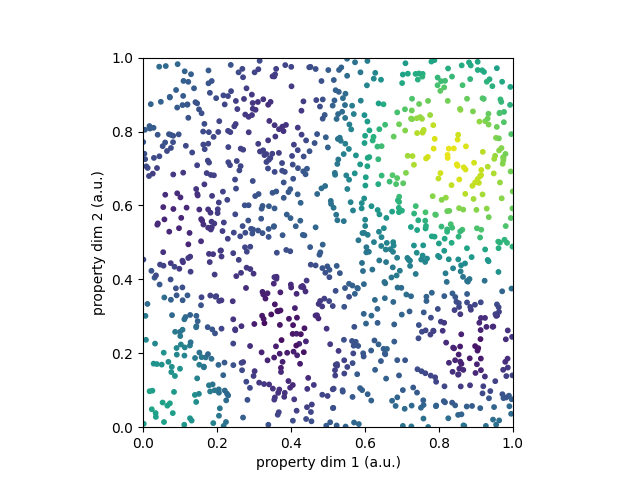

In [35]:
fit_w_clrs = cm.viridis((w_fit_mn_scaled - w_vis_min)/(w_vis_max - w_vis_min)).squeeze()
plt.figure()
ax = plt.subplot(1,1,1)

# Plot active neurons 
ax.scatter(ex_neuron_props[::sub_smp_int,0], ex_neuron_props[::sub_smp_int,1], 
           marker='.', color=fit_w_clrs[::sub_smp_int,:], s=40)

format_box(ax)
plt.savefig(type_save_loc / ('posterior_weights_s_' + str(ex_s_i) + '.pdf'), format='pdf')

## Visualize the mean and standard deviation of the true CPD 

<IPython.core.display.Javascript object>


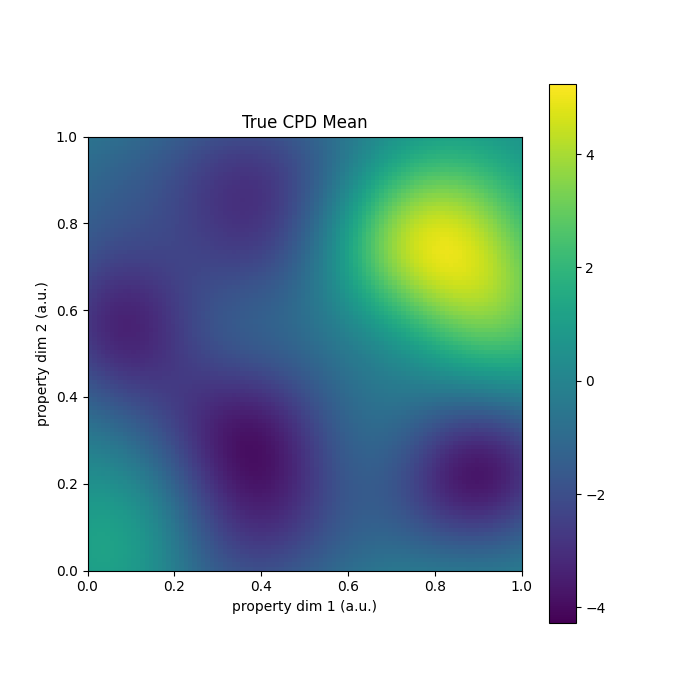

<IPython.core.display.Javascript object>


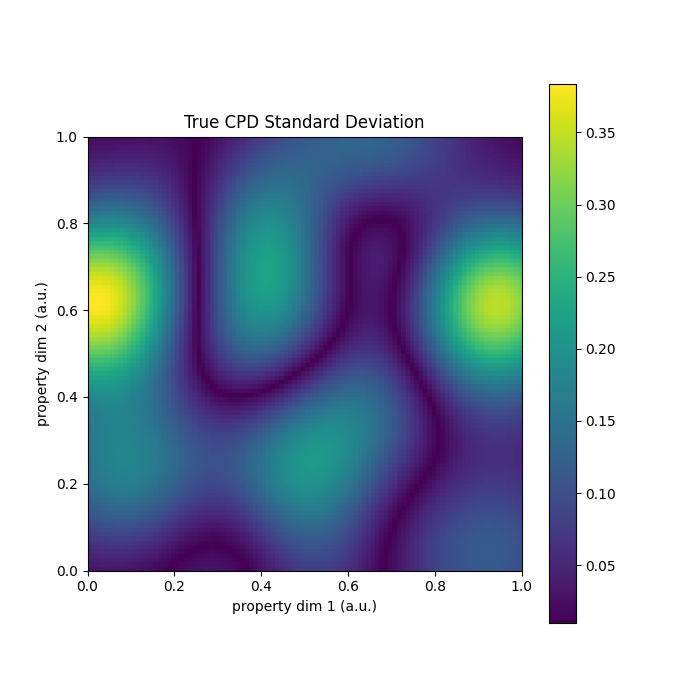

In [36]:
true_w_mn = true_priors.w_prior(pts).detach().numpy()
true_w_std = np.concatenate([d.std_f(pts).detach().cpu().numpy() for d in true_priors.w_prior.dists], axis=1)
true_w_mn_im = true_w_mn.reshape([100,100]).transpose()
true_w_std_im = true_w_std.reshape([100,100]).transpose()

plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(true_w_mn_im, origin='lower', extent=[0, 1.0, 0, 1.0], vmin=w_vis_min, vmax=w_vis_max)
plt.colorbar(im)
format_box(ax)
plt.title('True CPD Mean')
plt.savefig(save_folder / 'true_cpd_mean.pdf', format='pdf')

plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(true_w_std_im, origin='lower', extent=[0, 1.0, 0, 1.0])
std_vmin, std_vmax = im.get_clim() # Keep track of color limits
plt.colorbar(im)
format_box(ax)
plt.title('True CPD Standard Deviation')
plt.savefig(save_folder / 'true_cpd_std.pdf', format='pdf')

## Visualize the mean and standard deviation of the fit CPD

Sample fit CPD in a grid for visualization

In [37]:
fit_w_mn = fit_priors.w_prior(pts).detach().numpy()
fit_w_std = np.concatenate([d.std_f(pts).detach().cpu().numpy() for d in fit_priors.w_prior.dists], axis=1)

In [38]:
fit_w_mn_scaled = fit_w_mn*true_to_fit_cpd_sc
fit_w_std_scaled = fit_w_std*np.abs(true_to_fit_cpd_sc)

fit_w_mn_scaled_im = fit_w_mn_scaled.reshape([100,100]).transpose()
fit_w_std_scaled_im = fit_w_std_scaled.reshape([100,100]).transpose()

<IPython.core.display.Javascript object>


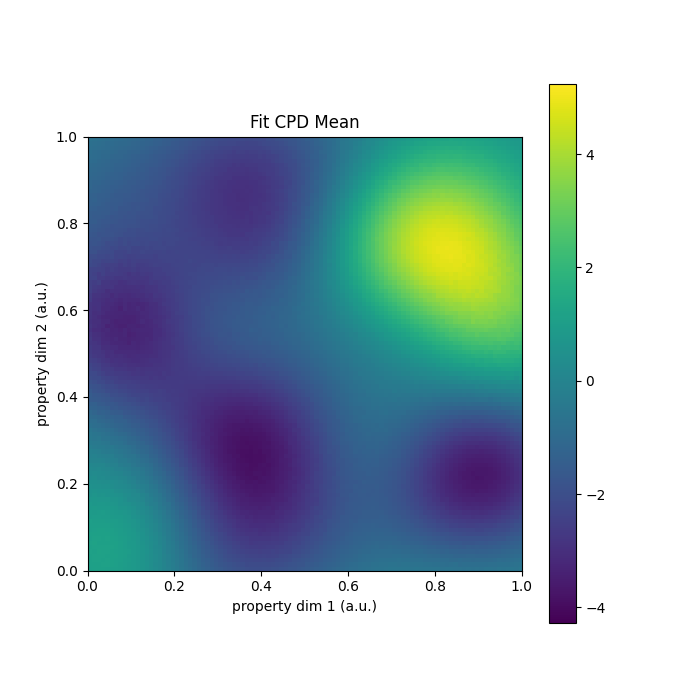

<IPython.core.display.Javascript object>


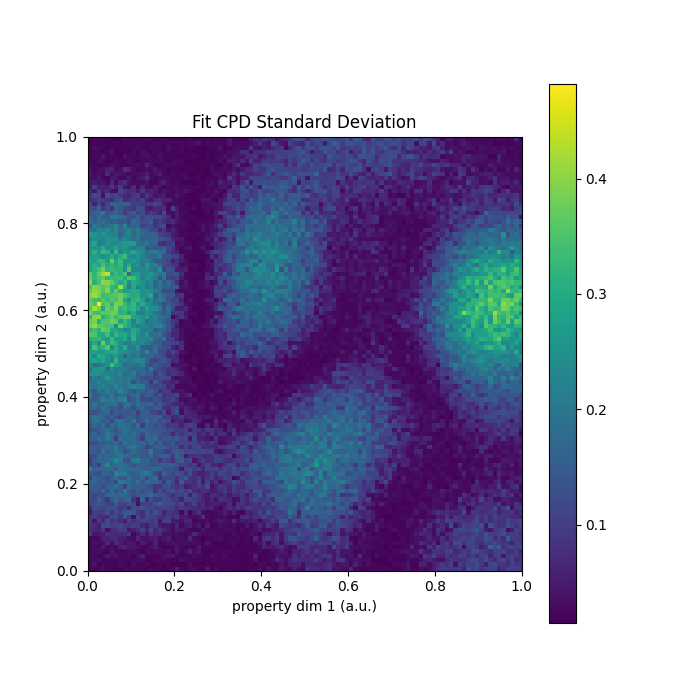

In [39]:
plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(fit_w_mn_scaled_im, origin='lower', extent=[0, 1.0, 0, 1.0], vmin=w_vis_min, vmax=w_vis_max)
plt.colorbar(im)
format_box(ax)
plt.title('Fit CPD Mean')
plt.savefig(type_save_loc / 'fit_cpd_mean.pdf', format='pdf')

plt.figure(figsize=(7, 7))
ax = plt.subplot(1,1,1)
im = ax.imshow(fit_w_std_scaled_im, origin='lower', extent=[0, 1.0, 0, 1.0])#, vmin=std_vmin, vmax=std_vmax)
plt.colorbar(im)
format_box(ax)
plt.title('Fit CPD Standard Deviation')
plt.savefig(type_save_loc / 'fit_cpd_std.pdf', format='pdf')

## Make a scatter plot of true vs fit mean for example subject 

Before plotting we first scale the fit weights to account for the non-identifiability in scale

<IPython.core.display.Javascript object>


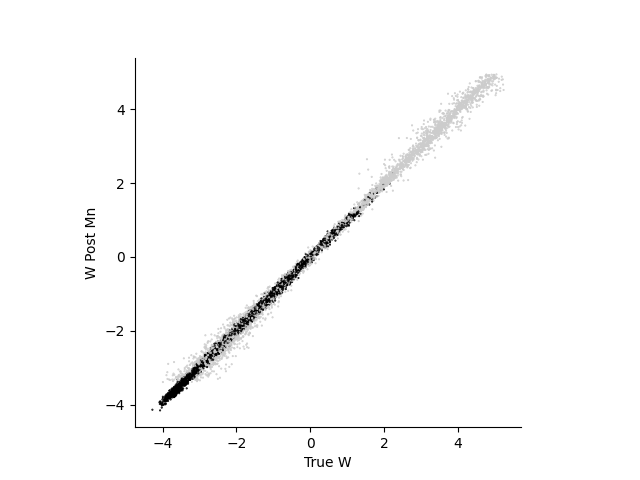

In [40]:
plt.figure()
ax = plt.subplot(1,1,1)

pts = np.concatenate([ex_true_neuron_weights, true_to_fit_cpd_sc*ex_w_fit_mn], axis=1)
clrs = np.zeros([pts.shape[0], 3])
clrs[~ex_active_neurons,:] = .8
    
# Here we permute the plotting order of the points so we don't create
# visualization artefacts of regions that look like they are all black or red.
rand_order = np.random.permutation(pts.shape[0])

plt.xlabel('True W')
plt.ylabel('W Post Mn')
ax.scatter(pts[rand_order,0], pts[rand_order,1], marker='.', color=clrs[rand_order,:], s=1)
ax.set_aspect('equal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



# Save the figure - use jpg due to large number of vector objects a eps/pdf would create
plt.savefig(type_save_loc / ('true_vs_est_w_s_' + str(ex_s_i) + '.jpg'), format='jpg')

## Evaluate model performance on test data for models fit to each example system together and individually

Evaluate model performance here

In [41]:
eval_rs = [None]*n_ex_systems
for i, s_i in enumerate(single_fit_inds):
    
    # ============================================================================================================
    # Generate data using the ground truth example system in two ways:
    #    1) The first is using the same active neurons and behavior range that was observed in the training data
    #    2 The second is using all neurons and all behavioral ranges
    
    # Here we generate data with the same active neurons and behevioral range as was in the training data for
    # this subject
    with torch.no_grad():
        x_i_train_domain = efficient_cone_and_projected_interval_sample(n_smps=n_eval_smps,
                                                                        locs=rs['ind_props'][s_i],
                                                                        ctr=torch.tensor([.5, .5]),
                                                                        ang_range=rs['ang_ranges'][s_i],
                                                                        w=rs['ind_true_mdls'][s_i].w.detach(),
                                                                        interval=rs['ind_intervals'][s_i],
                                                                        big_std=1.0,
                                                                        small_std=0,
                                                                        device=compute_device)
    
        # Before generating y data, move model to GPU (if possible)
        rs['ind_true_mdls'][s_i].to(compute_device)
        y_i_train_domain = rs['ind_true_mdls'][s_i].forward(x=x_i_train_domain)
    
        # Here we generate data when all neurons are active and for the full behavioral range
        x_i_full = efficient_cone_and_projected_interval_sample(n_smps=n_eval_smps,
                                                                locs=rs['ind_props'][s_i],
                                                                ctr=torch.tensor([.5, .5]),
                                                                ang_range=[0, 2*np.pi],
                                                                w=rs['ind_true_mdls'][s_i].w.detach(),
                                                                interval=[min_interval, max_interval],
                                                                big_std=1.0,
                                                                small_std=0,
                                                                device=compute_device)
        
        y_i_full = rs['ind_true_mdls'][s_i].forward(x=x_i_full)
        
        # Move true model back to cpu
        rs['ind_true_mdls'][s_i].to('cpu')
        
    # ============================================================================================================
    # Now we evaluate performance of the models fit collectively and individually 
    sing_i = np.argwhere(np.asarray(single_fit_inds) == s_i).item()
    
    comb_coll = comb_vi_colls[s_i]
    comb_coll.props = rs['ind_props'][s_i]
    comb_priors = comb_priors
    
    sing_coll = single_fits[sing_i]['vi_coll']
    sing_coll.props = rs['ind_props'][s_i]
    sing_priors = single_fits[sing_i]['priors']

    # Move the collections and priors to GPU (if possible) 
    comb_coll.to(compute_device)
    sing_coll.to(compute_device)
    comb_priors.to(compute_device)
    sing_priors.to(compute_device)
    
    # Evaluate model performance
    comb_train_domain_perf = eval_mdl_perf(x_i_train_domain, y_i_train_domain, comb_coll, comb_priors)
    sing_train_domain_perf = eval_mdl_perf(x_i_train_domain, y_i_train_domain, sing_coll, sing_priors)
    
    comb_full_perf = eval_mdl_perf(x_i_full, y_i_full, comb_coll, comb_priors)
    sing_full_perf = eval_mdl_perf(x_i_full, y_i_full, sing_coll, sing_priors)
    
    eval_rs[i] = {'s_i': s_i, 
                  'comb_train_domain_perf': comb_train_domain_perf,
                  'sing_train_domain_perf': sing_train_domain_perf,
                  'comb_full_perf': comb_full_perf, 
                  'sing_full_perf': sing_full_perf}
    
    # Move everything back to cpu
    comb_coll.to('cpu')
    sing_coll.to('cpu')
    comb_priors.to('cpu')
    sing_priors.to('cpu')
    
                  
    print('Done evaluating model performance for subject ' + str(s_i) + '.')
    

Done evaluating model performance for subject 0.
Done evaluating model performance for subject 1.
Done evaluating model performance for subject 2.
Done evaluating model performance for subject 3.
Done evaluating model performance for subject 4.
Done evaluating model performance for subject 5.
Done evaluating model performance for subject 6.
Done evaluating model performance for subject 7.
Done evaluating model performance for subject 8.
Done evaluating model performance for subject 9.
Done evaluating model performance for subject 10.
Done evaluating model performance for subject 11.
Done evaluating model performance for subject 12.
Done evaluating model performance for subject 13.
Done evaluating model performance for subject 14.
Done evaluating model performance for subject 15.
Done evaluating model performance for subject 16.
Done evaluating model performance for subject 17.
Done evaluating model performance for subject 18.
Done evaluating model performance for subject 19.
Done evalu

## Visualize model performance 

<IPython.core.display.Javascript object>


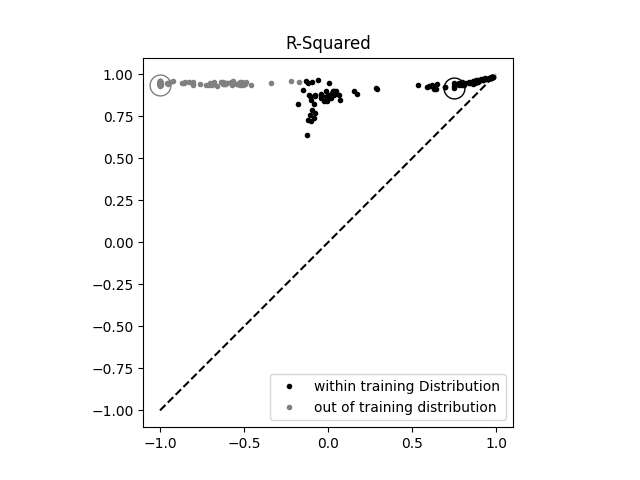

In [42]:
plt.figure()
ax = plt.subplot(1,1,1)
vis_perf(eval_rs, ax, 'r_sq', min_vl=-1, max_plot_vl=1, title='R-Squared', ex_i=ex_s_i)
plt.savefig(save_folder / 'perf_r_sq.pdf', format='pdf')

<IPython.core.display.Javascript object>


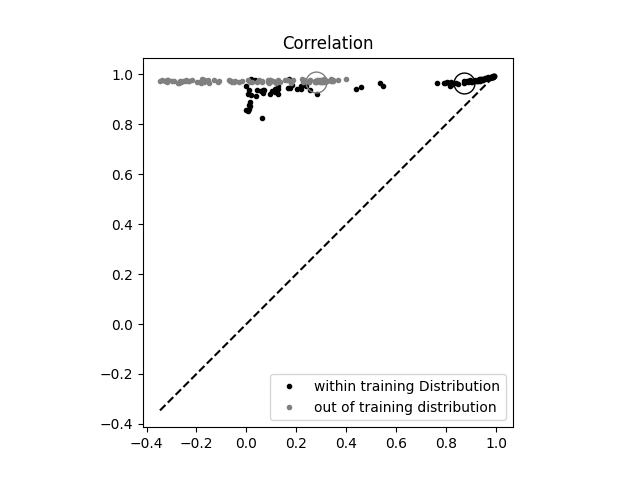

In [43]:
plt.figure()
ax = plt.subplot(1,1,1)
vis_perf(eval_rs, ax, 'corr', max_plot_vl=1, title='Correlation', ex_i=ex_s_i)
plt.savefig(save_folder / 'perf_corr.pdf', format='pdf')

<IPython.core.display.Javascript object>


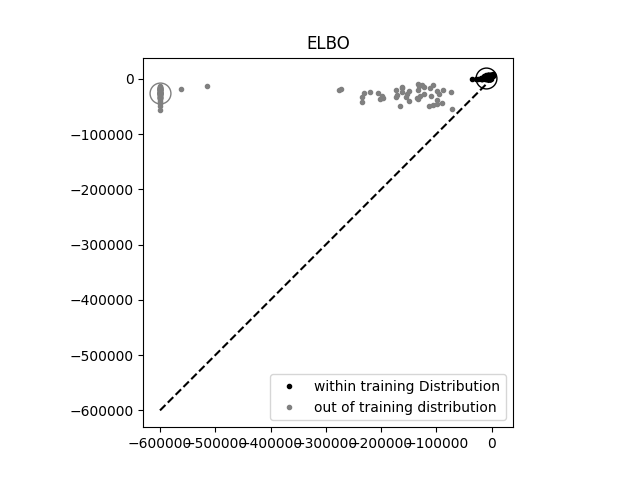

In [44]:
plt.figure()
ax = plt.subplot(1,1,1)
vis_perf(eval_rs, ax, 'elbo', min_vl=-600000.0, title='ELBO', ex_i=ex_s_i)
plt.savefig(save_folder / 'perf_elbo.pdf', format='pdf')

## Debug

In [45]:
fit_ps

{'n_ex_systems': 100,
 'n_input_var_range': [10000, 11000],
 'n_smps_range': [7500, 9000],
 'p': 1,
 'd_pred': 1,
 'true_w_prior_opts': {'n_bump_fcns': 50,
  'd_in': 2,
  'p': 1,
  'mn_m_std': 1.0,
  'std_m_std': 0.1,
  'bump_w': 0.2},
 'true_psi_prior_opts': {'conc_iv': 10.0,
  'rate_iv': 1000.0,
  'conc_lb': 1.0,
  'conc_ub': 1000.0,
  'rate_lb': 0.1,
  'rate_ub': 10000.0},
 's_in': tensor([0.0100]),
 'b_in': tensor([0.]),
 's_out': tensor([1.]),
 'b_out': tensor([0.]),
 'fit_w_prior_opts': {'mn_hc_params': {'n_divisions_per_dim': [100, 100],
   'dim_ranges': array([[-1.0000e-04,  1.0001e+00],
          [-1.0000e-04,  1.0001e+00]]),
   'n_div_per_hc_side_per_dim': [2, 2]},
  'std_hc_params': {'n_divisions_per_dim': [100, 100],
   'dim_ranges': array([[-1.0000e-04,  1.0001e+00],
          [-1.0000e-04,  1.0001e+00]]),
   'n_div_per_hc_side_per_dim': [2, 2]},
  'min_std': 1e-06,
  'mn_init': 0.0,
  'std_init': 0.01},
 'fit_psi_prior_opts': {'conc_iv': 10.0,
  'rate_iv': 1000.0,
  'conc